[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GP248CME215/PINN_tf2/blob/main/Burgers_equation_25_spring_TF2.ipynb)





In [ ]:
##############################################################################################################
# RUN THIS CODE BLOCK FIRST, it will load dependencies / install them if your system does not already have them.
##############################################################################################################

# tensorflow
try:
    # Try to import TensorFlow
    import tensorflow as tf
    print(f"TensorFlow is already installed. Version: {tf.__version__}")
except ImportError as e:
    # TensorFlow is not installed; install it
    print("TensorFlow is not installed. Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"Successfully installed TensorFlow. Version: {tf.__version__}")

# pyDOE
try:
    # Try to import pyDOE
    import pyDOE
    print(f"pyDOE is already installed.")
except ImportError as e:
    # pyDOE is not installed; install it
    print("pyDOE is not installed. Installing pyDOE...")
    !pip install pyDOE
    import pyDOE
    print(f"Successfully installed pyDOE.")


"""
@author: Yongji Wang, Yao Lai, Ray Chou (modified from Maziar Raissi)
"""
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(123)
tf.random.set_seed(123)

print(tf.__version__)

TensorFlow is already installed. Version: 2.18.0
pyDOE is not installed. Installing pyDOE...
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=701b185feaca6f483ed9cf497a7a2efdb52466802b8ec5d5f2d50379bfbe9c93
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Introduction

This notebook accompanies the CME 215 Spring 2025 Problem Set on **Physics-Informed Neural Networks (PINNs)**. The focus is on solving the **1D viscous Burgers’ equation**, a fundamental partial differential equation (PDE) in fluid dynamics that exhibits nonlinear convection and diffusion behavior. It is frequently used as a benchmark problem due to its rich mathematical structure and availability of an analytical solution.

We aim to solve the following form of the Burgers’ equation:

$\frac{\partial u}{\partial t} = \lambda_1 u \frac{\partial u}{\partial x} - \lambda_2 \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \quad t \in [0, 1]$,

where \( u(x,t) \) is the unknown velocity field, and $\lambda_1$, $\lambda_2$ are scalar parameters corresponding to advection and diffusion, respectively.

The initial and boundary conditions are given by:

$u(0, x) = -\sin(\pi x), \quad u(t, -1) = u(t, 1) = 0$.

In this notebook, we use a PINN model that incorporates both data and physical constraints into a unified loss function:
- **Data loss**: enforces agreement between the network prediction and known solution values at certain points
- **Physics loss**: enforces that the network prediction satisfies the PDE at collocation points in the domain

The model architecture uses a fully connected feedforward neural network with:
- 3 hidden layers, each with 20 neurons
- Activation functions: `tanh` and `sin` (compared experimentally)
- A single output node representing $u(x,t)$

We train the model using the Adam optimizer and evaluate it against the ground truth solution loaded from `burgers_shock.mat`.


# Neural Network Implementation

In [ ]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        # Domain bounds for input normalization
        self.lb = lb
        self.ub = ub

        # Split supervised data inputs (with known solution u) into x and t
        self.x_u = X_u[:, 0:1]
        self.t_u = X_u[:, 1:2]

        # Split collocation points (where PDE is enforced) into x and t
        self.x_f = X_f[:, 0:1]
        self.t_f = X_f[:, 1:2]

        # Known solution at supervised points
        self.u = u

        # Network architecture and PDE parameter
        self.layers = layers
        self.nu = nu

        # Initialize neural network weights and biases
        self.weights, self.biases = self.initialize_NN(layers)

        # All trainable parameters for optimization
        self.train_variables = self.weights + self.biases
        # These are tf.Variable objects so updates here affect the model directly

        # Initialize loss (this is not necessary here but allows pre-evaluation)
        self.loss = self.loss_NN()

    '''
    Neural Network Initialization Functions
    =======================================
    '''

    def initialize_NN(self, layers):
        # Initialize weights and biases for each layer using Xavier init
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        # Xavier/Glorot initialization to avoid vanishing/exploding gradients
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        # Forward pass through the fully connected feedforward neural network
        num_layers = len(weights) + 1

        # Normalize inputs to [-1, 1] using domain bounds
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0

        # Hidden layers with tanh activation
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        # Output layer (linear activation)
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    '''
    Physics-Informed PDE Modeling
    =============================
    '''

    def net_u(self, x, t):
        # Predict u(x, t) by feeding concatenated input into the network
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u

    def net_f(self, x, t):
        # Construct the PDE residual f(x, t) = u_t + u*u_x - nu*u_xx using autograd
        X = tf.concat([x, t], axis=1)

        with tf.GradientTape(persistent=True) as tape:
            tape.watch([x, t])

            # Forward pass: predict u(x,t)
            u = self.net_u(x, t)

            # Compute gradients: first-order
            u_x = tape.gradient(u, x)
            u_t = tape.gradient(u, t)

            # Compute second-order gradient: u_xx
            u_xx = tape.gradient(u_x, x)

        # Burgers' equation residual
        f = u_t + u * u_x - self.nu * u_xx
        return f

    @tf.function
    def loss_NN(self):
        # Compute the total loss: data loss + PDE residual loss

        # Prediction of u at supervised data points
        self.u_pred = self.net_u(self.x_u, self.t_u)

        # Residual of PDE at collocation points
        self.f_pred = self.net_f(self.x_f, self.t_f)

        # Mean squared error between predicted and known u
        loss_data = tf.reduce_mean(tf.square(self.u - self.u_pred))

        # Mean squared error of PDE residual
        loss_eq = tf.reduce_mean(tf.square(self.f_pred))

        # Total loss = data loss + physics loss (unweighted here)
        return loss_data + loss_eq

    def train(self, nIter: int, learning_rate: float):
        """
        Train the model using Adam optimizer and gradient clipping.
        Uses exponential decay learning rate and logs progress every 100 iterations.
        """
        # Exponential learning rate decay, to help release the issue of training loss oscilation
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=200,
            decay_rate=0.9
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        varlist = self.weights + self.biases  # All trainable variables

        # Logging variables
        start_time = time.time()
        it_list = []
        loss_list = []

        for it in range(nIter):
            with tf.GradientTape() as tape:
                loss = self.loss_NN()

            # Compute gradients of loss w.r.t. weights and biases
            grads = tape.gradient(loss, varlist)

            # Optional: clip gradients to prevent exploding updates
            clipped_grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]

            # Apply gradients to update model parameters
            optimizer.apply_gradients(zip(clipped_grads, varlist))

            # Logging
            it_list.append(it)
            loss_list.append(loss)

            if (it + 1) % 100 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Train Loss: %.3e, Time: %.2f' % (it, loss.numpy(), elapsed))
                start_time = time.time()

        return it_list, loss_list

    @tf.function
    def predict(self, X_star):
        # Evaluate the trained model: predict both u and f at new points
        u_star = self.net_u(X_star[:, 0:1], X_star[:, 1:2])
        f_star = self.net_f(X_star[:, 0:1], X_star[:, 1:2])
        return u_star, f_star


In [ ]:
# access the data on GitHub:
!wget -O burgers_shock.mat https://raw.githubusercontent.com/GP248CME215/PINN_tf2/main/burgers_shock.mat

--2025-04-22 21:21:39--  https://raw.githubusercontent.com/GP248CME215/PINN_tf2/main/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.03s   

2025-04-22 21:21:39 (5.81 MB/s) - ‘burgers_shock.mat’ saved [207944/207944]



# Data Initialization
We load \texttt{burgers\_shock.mat}, which contains the numerical solution to the one-dimensional Burgers' equation. The dataset provides a matrix \texttt{usol} of shape $256 \times 100$, representing the solution $u(x, t)$ evaluated over a spatial grid $x$ and temporal grid $t$. Specifically, the spatial domain is defined over $-1 \leq x \leq 1$, and the temporal domain spans $0 \leq t \leq 1$. The range of the solution itself is also bounded within $-1 \leq u \leq 1$.

It is important to ensure that the input variables $x$, $t$, and $u$ are on a relatively small scale when feeding them into a neural network. Smaller input values help improve the stability of training and prevent issues such as exploding or vanishing gradients, especially when using activation functions like $\tanh$ or sigmoid. They also help ensure that the weights and biases of the model evolve smoothly during optimization, making the learning process more efficient.

In this dataset, the inputs are already normalized within the range $[-1, 1]$, so no additional preprocessing is required before using them as input to the neural network.


x shape: (256,), t shape: (100,), usol shape: (100, 256)


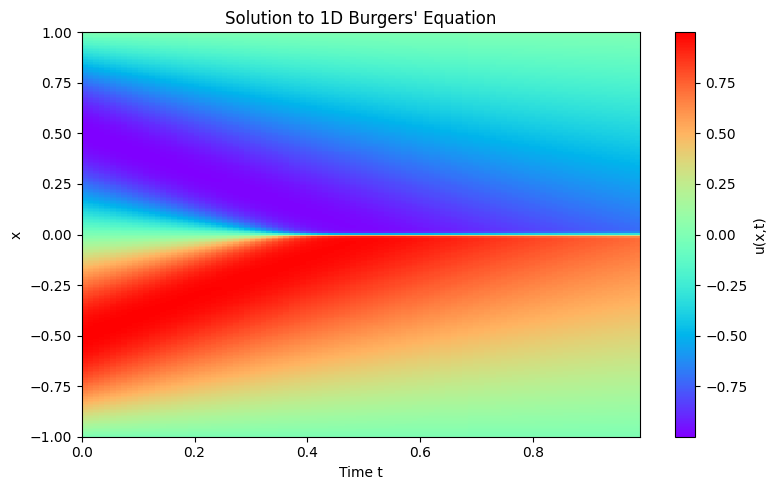

In [ ]:
# Load the data
data = scipy.io.loadmat('burgers_shock.mat')

# Extract variables
t = data['t'].squeeze()     # shape (100,)
x = data['x'].squeeze()     # shape (256,)
Exact = np.real(data['usol']).T        # shape (256, 100)

print(f"x shape: {x.shape}, t shape: {t.shape}, usol shape: {Exact.shape}")
# Note,

# Plot the 2D field u(x, t)
plt.figure(figsize=(8, 5))
plt.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
           extent=[t.min(), t.max(), x.min(), x.max()],
           origin='lower', aspect='auto')
plt.xlabel('Time t')
plt.ylabel('x')
plt.title("Solution to 1D Burgers' Equation")
plt.colorbar(label='u(x,t)')
plt.tight_layout()
plt.show()


In [ ]:
# train the model
nu = 0.01/np.pi
# noise = 0.0

N_u = 100  #
N_f = 10000   # n

X, T = np.meshgrid(x,t) #  X, T dimensions: 100 x 256
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  # dimension of 25600 x 2
u_star = Exact.flatten()[:,None]                                # dimension of 25600 x 1

# Domain bounds
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)


xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))   #x,t coordinates of the training data at t=0
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))       #x,t coordinates of the training data at x=1
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))       #x,t coordinates of the training data at x=-1
uu3 = Exact[:,-1:]
X_u_train = np.vstack([xx1, xx2, xx3])      #x,t coordinates of all training data at t=0, x=1, x=-1
X_f_train = lb + (ub-lb)*lhs(2, N_f)        #x,t coordinates of all collocation points
# LHS: Latin Hypercube Sampling, https://pythonhosted.org/pyDOE/randomized.html
# This youtube video may help you with understanding what Latin Hypercube Sampling is
# https://www.youtube.com/watch?v=ugy7XC-cMb0
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]



X_u_train = tf.cast(X_u_train, dtype=tf.float32)
u_train = tf.cast(u_train, dtype=tf.float32)
X_f_train = tf.cast(X_f_train, dtype=tf.float32)

# NN initialization and Training!
This might take a few minutes

In [ ]:
layers = [2, 20, 20, 20, 1]
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

start_time = time.time()
it_list, loss_list = model.train(5000, learning_rate=5e-2)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

### Note, here we only require you to train 5k iterations, which is sufficient for this P-set.
### If you don't exactly match what Figure 1 (Pset2 pdf) shows, it is totally fine as it takes more iterations and time to train,
### and we are not asking you to fully reproduce the figure 100%. But you are supposed to get something
### close to it.

It: 99, Train Loss: 9.404e-02, Time: 18.27
It: 199, Train Loss: 7.141e-02, Time: 10.70
It: 299, Train Loss: 1.500e-01, Time: 7.61
It: 399, Train Loss: 5.764e-02, Time: 7.77
It: 499, Train Loss: 5.053e-02, Time: 8.18
It: 599, Train Loss: 4.979e-02, Time: 7.08
It: 699, Train Loss: 4.026e-02, Time: 7.97
It: 799, Train Loss: 3.299e-02, Time: 7.69
It: 899, Train Loss: 2.676e-02, Time: 7.40
It: 999, Train Loss: 2.334e-02, Time: 8.07
It: 1099, Train Loss: 1.969e-02, Time: 7.09
It: 1199, Train Loss: 1.707e-02, Time: 8.08
It: 1299, Train Loss: 1.928e-02, Time: 8.76
It: 1399, Train Loss: 1.681e-02, Time: 7.14
It: 1499, Train Loss: 1.241e-02, Time: 8.36
It: 1599, Train Loss: 1.506e-02, Time: 7.18
It: 1699, Train Loss: 7.735e-03, Time: 8.25
It: 1799, Train Loss: 7.134e-03, Time: 8.07
It: 1899, Train Loss: 6.205e-03, Time: 7.14
It: 1999, Train Loss: 6.990e-03, Time: 8.28
It: 2099, Train Loss: 5.417e-03, Time: 7.64
It: 2199, Train Loss: 8.720e-03, Time: 8.81
It: 2299, Train Loss: 5.412e-03, Time: 8.

# Post Training Evaluation

In [ ]:
### Make prediction on the mesh of the entire field
X_star = tf.cast(X_star, dtype=tf.float32)
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))

U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 1.906867e-01


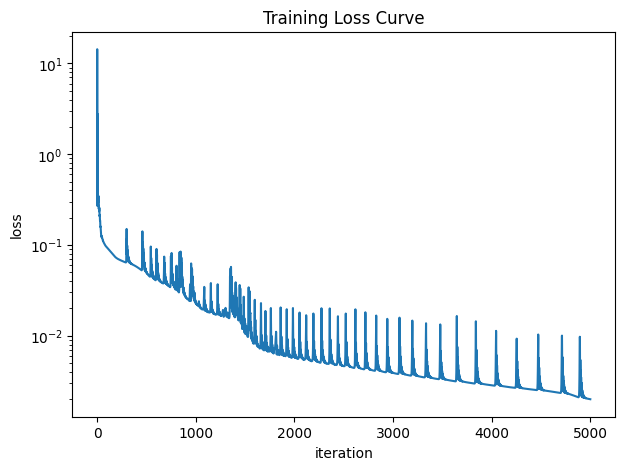

In [ ]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(it_list, loss_list)
ax.set_title('Training Loss Curve')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.show()

### Note it is common that you observe oscilations of loss curve along the training proceeds, this is due to
### Adam optimizer. To eliminate the oscilations you can try learning rate schedulers, i.e.
### tf.keras.optimizers.schedules.ExponentialDecay introduced in the training function (no guaranteed, osicilations
### can still be seen here). Or you can try L-BFGS optimizer (not implemented in this code)
### see https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/lbfgs_minimize

Text(0.5, 1.0, '$t = 0.75$')

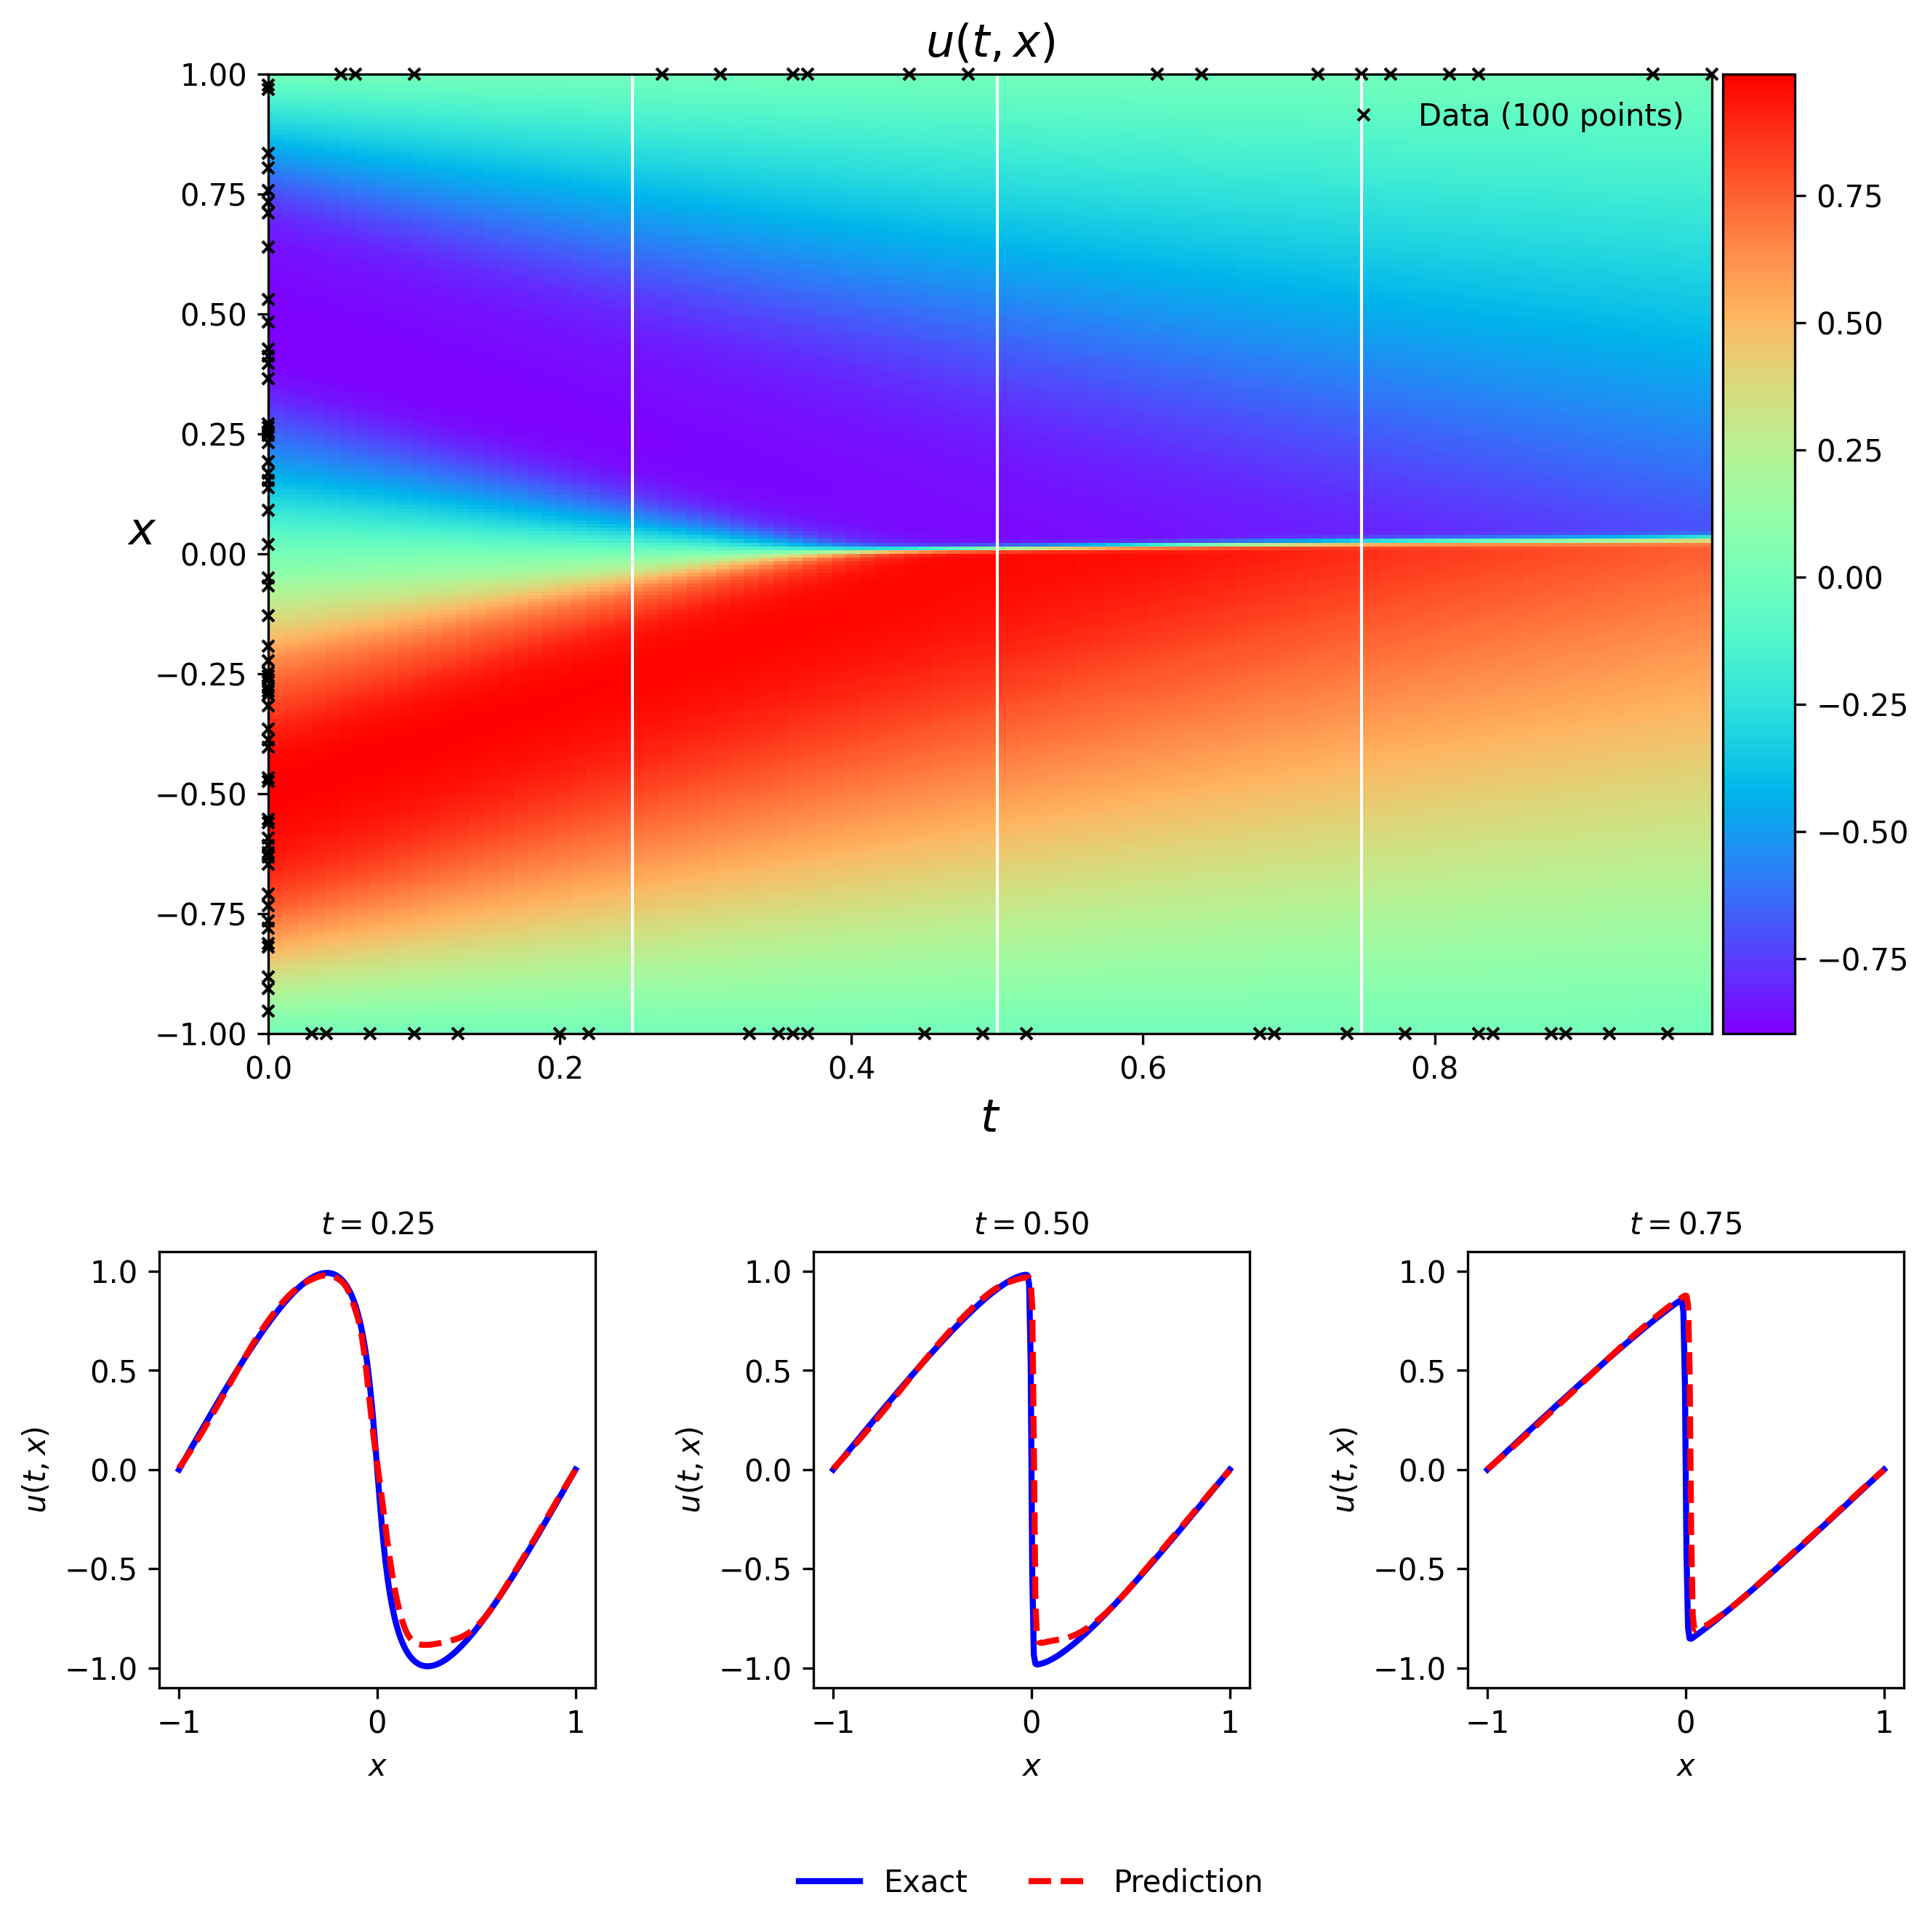

In [ ]:
fig = plt.figure(figsize = [10, 10], dpi = 300)

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/2, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)


ax.set_xlabel('$t$', fontsize = 15)
ax.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax.set_title('$u(t,x)$', fontsize = 15)
ax.legend(frameon=False, loc = 'best')

####### Row 1: u(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/2, bottom=0.1, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.75$', fontsize = 10)